__1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями.__

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
path_brent = '../data/my_BRENT2019.csv'
brent = pd.read_csv(path_brent, index_col=[0], parse_dates=[0], usecols=['Дата', 'Значение'])
brent['brent_diff'] = brent['Значение'].diff(1).fillna(0)
brent.drop(columns='Значение', inplace=True)
brent.head()

,brent_diff
Дата,
2010-09-01,0.00
2010-09-02,0.52
2010-09-03,-0.32
2010-09-04,0.05
2010-09-05,0.01


__2. Добавьте первые разности по стоимости доллара и евро к рублю.__

In [3]:
rub_doll=pd.read_excel('../data/RC_F01_09_2010_T01_09_2019.xlsx')
rub_doll.index = pd.to_datetime(rub_doll['data'].values).date
rub_doll.drop(['nominal','cdx','data'], axis=1, inplace = True)
rub_doll.head()

,curs
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-07,30.5771


In [4]:
rub_e=pd.read_excel('../data/R_E01_09_2010_T01_09_2019.xlsx')
rub_e.index = pd.to_datetime(rub_e['data'].values).date
rub_e.drop(['nominal','cdx','data'], axis=1, inplace = True)
rub_e.head()

,curs
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-07,39.4720


In [5]:
brent['usd_diff'] = rub_doll['curs'].diff(1)
brent['eur_diff'] = rub_e['curs'].diff(1)
brent.tail(10)

,brent_diff,usd_diff,eur_diff
Дата,,,
2019-08-21,0.33,0.1758,0.0282
2019-08-22,-0.33,-0.5210,-0.4777
2019-08-23,-1.11,-0.6434,-0.6677
2019-08-25,-1.13,NaN,NaN
2019-08-26,0.45,NaN,NaN
2019-08-27,1.33,0.3689,0.7712
2019-08-28,0.25,0.2873,0.2136
2019-08-29,0.53,0.1519,0.0492
2019-08-30,-1.18,0.3344,0.2975


Есть пропуски значений курса, что связано, скорее всего, с выходными днями, когда валюта не торговалась. Поскольку мы используем первые разности, то допустим, что курс за эти дни не менялся, и заполним пропуски нулями.

In [6]:
brent.fillna(0, inplace=True)
brent.tail(10)

,brent_diff,usd_diff,eur_diff
Дата,,,
2019-08-21,0.33,0.1758,0.0282
2019-08-22,-0.33,-0.5210,-0.4777
2019-08-23,-1.11,-0.6434,-0.6677
2019-08-25,-1.13,0.0000,0.0000
2019-08-26,0.45,0.0000,0.0000
2019-08-27,1.33,0.3689,0.7712
2019-08-28,0.25,0.2873,0.2136
2019-08-29,0.53,0.1519,0.0492
2019-08-30,-1.18,0.3344,0.2975


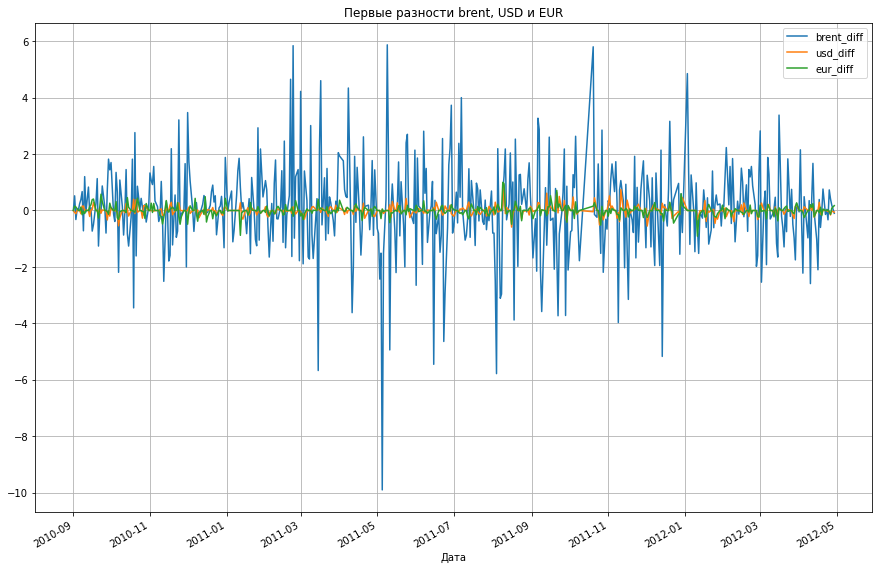

In [7]:
size_data = 500

brent['brent_diff'][:size_data].plot(label='brent_diff', figsize=(15, 10))
brent['usd_diff'][:size_data].plot(label='usd_diff')
brent['eur_diff'][:size_data].plot(label='eur_diff')
plt.legend()
plt.grid()
plt.title('Первые разности brent, USD и EUR')
plt.show()

__3. Сделайте ее перрасчет (ресемплинг) в представление по неделям.__

In [8]:
brent_w = brent.resample('W').mean().fillna(0)
brent_w.head()

,brent_diff,usd_diff,eur_diff
Дата,,,
2010-09-05,0.052000,-0.034940,0.067560
2010-09-12,0.288333,0.033583,-0.026467
2010-09-19,-0.021667,0.021433,0.187483
2010-09-26,0.118333,-0.013250,0.121083
2010-10-03,0.791667,-0.072567,0.029883


__4. Постройте модель предсказания 1-й точки от текущей (h=1).__

In [9]:
from sklearn.model_selection import train_test_split

h = 1

X_train, X_test, y_train, y_test = train_test_split(brent_w.values[:-h],
                                                    brent_w['brent_diff'].values[h:],
                                                    test_size=0.2,
                                                    shuffle=False)

Используем GradientBoostingRegressor.

In [10]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [11]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

model = GradientBoostingRegressor(random_state=21)
model.fit(X_train, y_train)
pred = model.predict(X_test)

print(r2_score(y_test, pred))
print(mean_absolute_percentage_error(y_test, pred))

-0.05088309916950862
148.46440584598935


In [12]:
from statsmodels.tsa.api import VAR

model = VAR(brent_w)
model.select_order(maxlags=12).summary()

,AIC,BIC,FPE,HQIC
0,-9.033,-9.006*,0.0001194,-9.023*
1,-9.033,-8.925,0.0001194,-8.990
2,-9.061*,-8.872,0.0001161*,-8.986
3,-9.052,-8.782,0.0001171,-8.946
4,-9.049,-8.697,0.0001175,-8.910
5,-9.027,-8.594,0.0001202,-8.857
6,-9.021,-8.508,0.0001208,-8.819
7,-9.018,-8.424,0.0001212,-8.784
8,-8.995,-8.319,0.0001241,-8.729
9,-8.986,-8.230,0.0001251,-8.688


In [13]:
model_fit = model.fit(2)
pred_var = model_fit.forecast(model_fit.endog, steps=len(y_test))[:, 0]

In [14]:
print(r2_score(y_test, pred_var))

0.0006707926323334945


In [15]:
brent_w.columns

Index(['brent_diff', 'usd_diff', 'eur_diff'], dtype='object')

In [16]:
brent_w['roll_4'] = brent_w['brent_diff'].rolling(window=4).mean()
brent_w['roll_5'] = brent_w['brent_diff'].rolling(window=5).mean()

In [17]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

for a in range(1, 9):
    brent_w[f'exp_0_0{a}'] = exponential_smoothing(brent_w['brent_diff'], a*0.01)

In [18]:
q = 52
for i in range(q):
    brent_w['q_'+str(i+1)] = 0.
    brent_w['q_'+str(i+1)].values[i+1:] = brent_w['brent_diff'].values[:-(i+1)]

In [19]:
from sklearn.model_selection import train_test_split

h = 1

X_train, X_test, y_train, y_test = train_test_split(brent_w.values[q:-h],
                                                    brent_w['brent_diff'].values[q+h:],
                                                    test_size=0.2,
                                                    shuffle=False)

In [20]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train_sc = scaler_x.fit_transform(X_train)
y_train_sc = scaler_y.fit_transform(y_train.reshape(-1, 1))

X_test_sc = scaler_x.transform(X_test)
y_test_sc = scaler_y.transform(y_test.reshape(-1, 1))

In [21]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.feature_selection import f_regression, mutual_info_regression

best_f_score_colmns = []
threshold_f = 0.29 # порог важности признака

f_test, _ = f_regression(X_train_sc, y_train_sc.ravel())
f_test /= np.max(f_test)
for i in range(X_train_sc.shape[1]):
#     print("F-test={:.2f},  I={}".format(f_test[i],i))
    if f_test[i] > threshold_f:
        best_f_score_colmns.append(i)
        
column_names_f = brent_w.iloc[q:-h,:].columns[best_f_score_colmns]
print(column_names_f)

Index(['q_34', 'q_45', 'q_48', 'q_51'], dtype='object')


In [22]:
sfk = SelectKBest(f_regression, k=7)
X_new1 = sfk.fit_transform(X_train_sc, y_train_sc.ravel())
column_names_k = brent_w.columns[sfk.get_support()]
column_names_k

Index(['q_5', 'q_13', 'q_29', 'q_34', 'q_45', 'q_48', 'q_51'], dtype='object')

In [23]:
sfp = SelectPercentile(f_regression, percentile=15)
X_new2 = sfp.fit_transform(X_train_sc, y_train_sc.ravel())
column_names_p = brent_w.columns[sfp.get_support()]
column_names_p

Index(['q_1', 'q_5', 'q_13', 'q_29', 'q_34', 'q_35', 'q_43', 'q_45', 'q_48',
       'q_51'],
      dtype='object')

In [24]:
list_param = list(set(column_names_f.append(column_names_k).append(column_names_p)))
print(list_param)

['q_43', 'q_1', 'q_35', 'q_51', 'q_45', 'q_48', 'q_13', 'q_34', 'q_29', 'q_5']


In [25]:
numb_columns = [brent_w.columns.get_loc(param) for param in list_param]
X_train_sc_new = X_train_sc[:, numb_columns]
X_test_sc_new = X_test_sc[:, numb_columns]

In [26]:
from sklearn.model_selection import GridSearchCV

papameters = [{'n_estimators': np.arange(100, 800, 100),
               'max_depth': np.arange(2, 9), 
               'min_samples_leaf': np.arange(1, 6)}]

clf = GridSearchCV(estimator=GradientBoostingRegressor(random_state=21, n_iter_no_change=30),
                   param_grid=papameters,
                   scoring='r2',
                   n_jobs=-1)

clf.fit(X_train_sc_new, y_train_sc.ravel())

clf.best_params_

{'max_depth': 2, 'min_samples_leaf': 3, 'n_estimators': 100}

In [27]:
model = GradientBoostingRegressor(random_state=21, max_depth=2, min_samples_leaf=1, n_estimators=100)
model.fit(X_train_sc_new, y_train_sc.ravel())
pred = model.predict(X_test_sc_new)

print(r2_score(y_test_sc, pred))

-0.04477497660407992


__5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.__

Первые разности цены нефти и курсов валют близки по распределению к шуму, без самих значений предсказывать разности с достаточной точностью нельзя.